# 2.2 Coalition or Sum: numerical comparisons
## 2.2.1 Toy model

In [1]:
import warnings
warnings.filterwarnings('ignore')

from acv_explainers import ACVTree
import shap

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import random 
import numpy as np
import pandas as pd
import seaborn as sns

random.seed(2021)
np.random.seed(2021)

In [2]:
from experiments.exp_linear_gmm import *
from experiments.exp_linear_gmm_ohe import *

In [3]:
# Fixed the seed and plot env
random.seed(2019)
np.random.seed(2019)


plt.style.use(['ggplot'])

###  Data init

In [4]:
## Generate new random covariance matrix 

# d = 3
# # p = 0.
# # cov = {key: np.array([[1, p, p, p], [p, 1, p, p], [p, p, 1, p], [p, p, p, 1]]) for key in ['a', 'b', 'c']}
# cov = {}
# for key in ['a', 'b', 'c']:
#     b = np.random.randn(d, d)
#     cov[key] = np.dot(b, b.T)
# cov

In [5]:
d = 3

cov = {'a': np.array([[ 0.41871254, -0.79006136,  0.46956991],
        [-0.79006136,  1.90865098, -0.82571655],
        [ 0.46956991, -0.82571655,  0.95835472]]),
 'b': np.array([[ 0.55326081,  0.11811951, -0.70677924],
        [ 0.11811951,  2.73312979, -2.94400196],
        [-0.70677924, -2.94400196,  4.22105088]]),
 'c': np.array([[ 9.2859966 ,  1.12872646,  2.4224434 ],
        [ 1.12872646,  0.92891237, -0.14373393],
        [ 2.4224434 , -0.14373393,  1.81601676]])}

In [6]:
n = 40000
# mean_a = np.random.randn(d)
# mean_b = np.random.randn(d)
# mean_c = np.random.randn(d)

mean_a = np.zeros(d)
mean_b = np.zeros(d)
mean_c = np.zeros(d)


exp = ExperimentsLinearGMM(mean={'a': mean_a, 'b': mean_b, 'c': mean_c}, cov=cov,
                           coefs={'a': [1, 3, 5], 'b': [-5, -10, -8], 'c': [6, 1, 0]},
                           pi={'a': 0.3, 'b': 0.3, 'c': 0.4}, n=n, C=[[3, 4]],
                           cat_index=[3, 4])

exp_ohe = ExperimentsLinearGMMOhe(mean={'a': mean_a, 'b': mean_b, 'c': mean_c}, cov=cov,
                           coefs={'a': [1, 3, 5], 'b': [-5, -10, -8], 'c': [6, 1, 0]},
                           pi={'a': 0.3, 'b': 0.3, 'c': 0.4}, n=n, C=[[3, 4, 5]],
                           cat_index=[3, 4, 5])


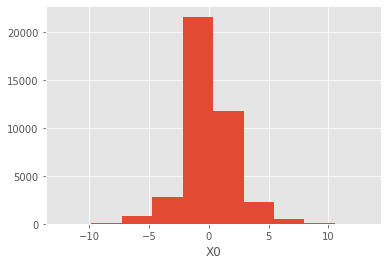

In [7]:
# Range of X0...

plt.figure()
plt.hist(exp.data[:, 0])
plt.xlabel('X0')
plt.show()

### Sample new observations by varying X0

In [8]:
nb = 100
x_0 = np.linspace(-4, 2, nb)
sample = []
sample_shap = []
sample_shap_c = []
sample_shap_ohe = []
for x in tqdm(x_0):
    a = sampleMVN(1, exp.mean['a'], exp.cov['a'], [1, 2], [0], x)
    sample.append(np.concatenate(([x], a[0], [1, 0, 0])))    
    
    exp.C = [[]]
    sample_shap.append(exp.linear_gmm_shap(sample[-1][:-1], False))
    
    exp.C = [[]]
    sample_shap_ohe.append(exp_ohe.linear_gmm_shap(sample[-1], False))
    
    exp.C = [[3, 4]]
    sample_shap_c.append(exp.linear_gmm_shap(sample[-1][:-1], False))

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


## Coalition or Sum: numerical comparisons

In [9]:
s_shap = np.round(np.array(sample_shap), 3)
s_shap_ohe = np.round(np.array(sample_shap_ohe), 3)
s_shap_c = np.round(np.array(sample_shap_c), 3)


s_shap_sum = np.round(s_shap.copy(), 3)
sum_v = s_shap_sum[:, 3] + s_shap_sum[:, 4]
s_shap_sum[:, 3] = sum_v
s_shap_sum[:, 4] = sum_v
s_shap_sum = np.round(s_shap_sum, 3)


s_shap_ohe_sum = np.round(s_shap_ohe.copy(), 3)
sum_v = s_shap_ohe_sum[:, 3] + s_shap_ohe_sum[:, 4] + s_shap_ohe_sum[:, 5] 
s_shap_ohe_sum[:, 3] = sum_v
s_shap_ohe_sum[:, 4] = sum_v
s_shap_ohe_sum[:, 5] = sum_v
s_shap_ohe_sum = np.round(s_shap_ohe_sum, 3)

variables_name = ['X{}'.format(i) for i in range(len(s_shap_c[0])-2)] + ['Y']

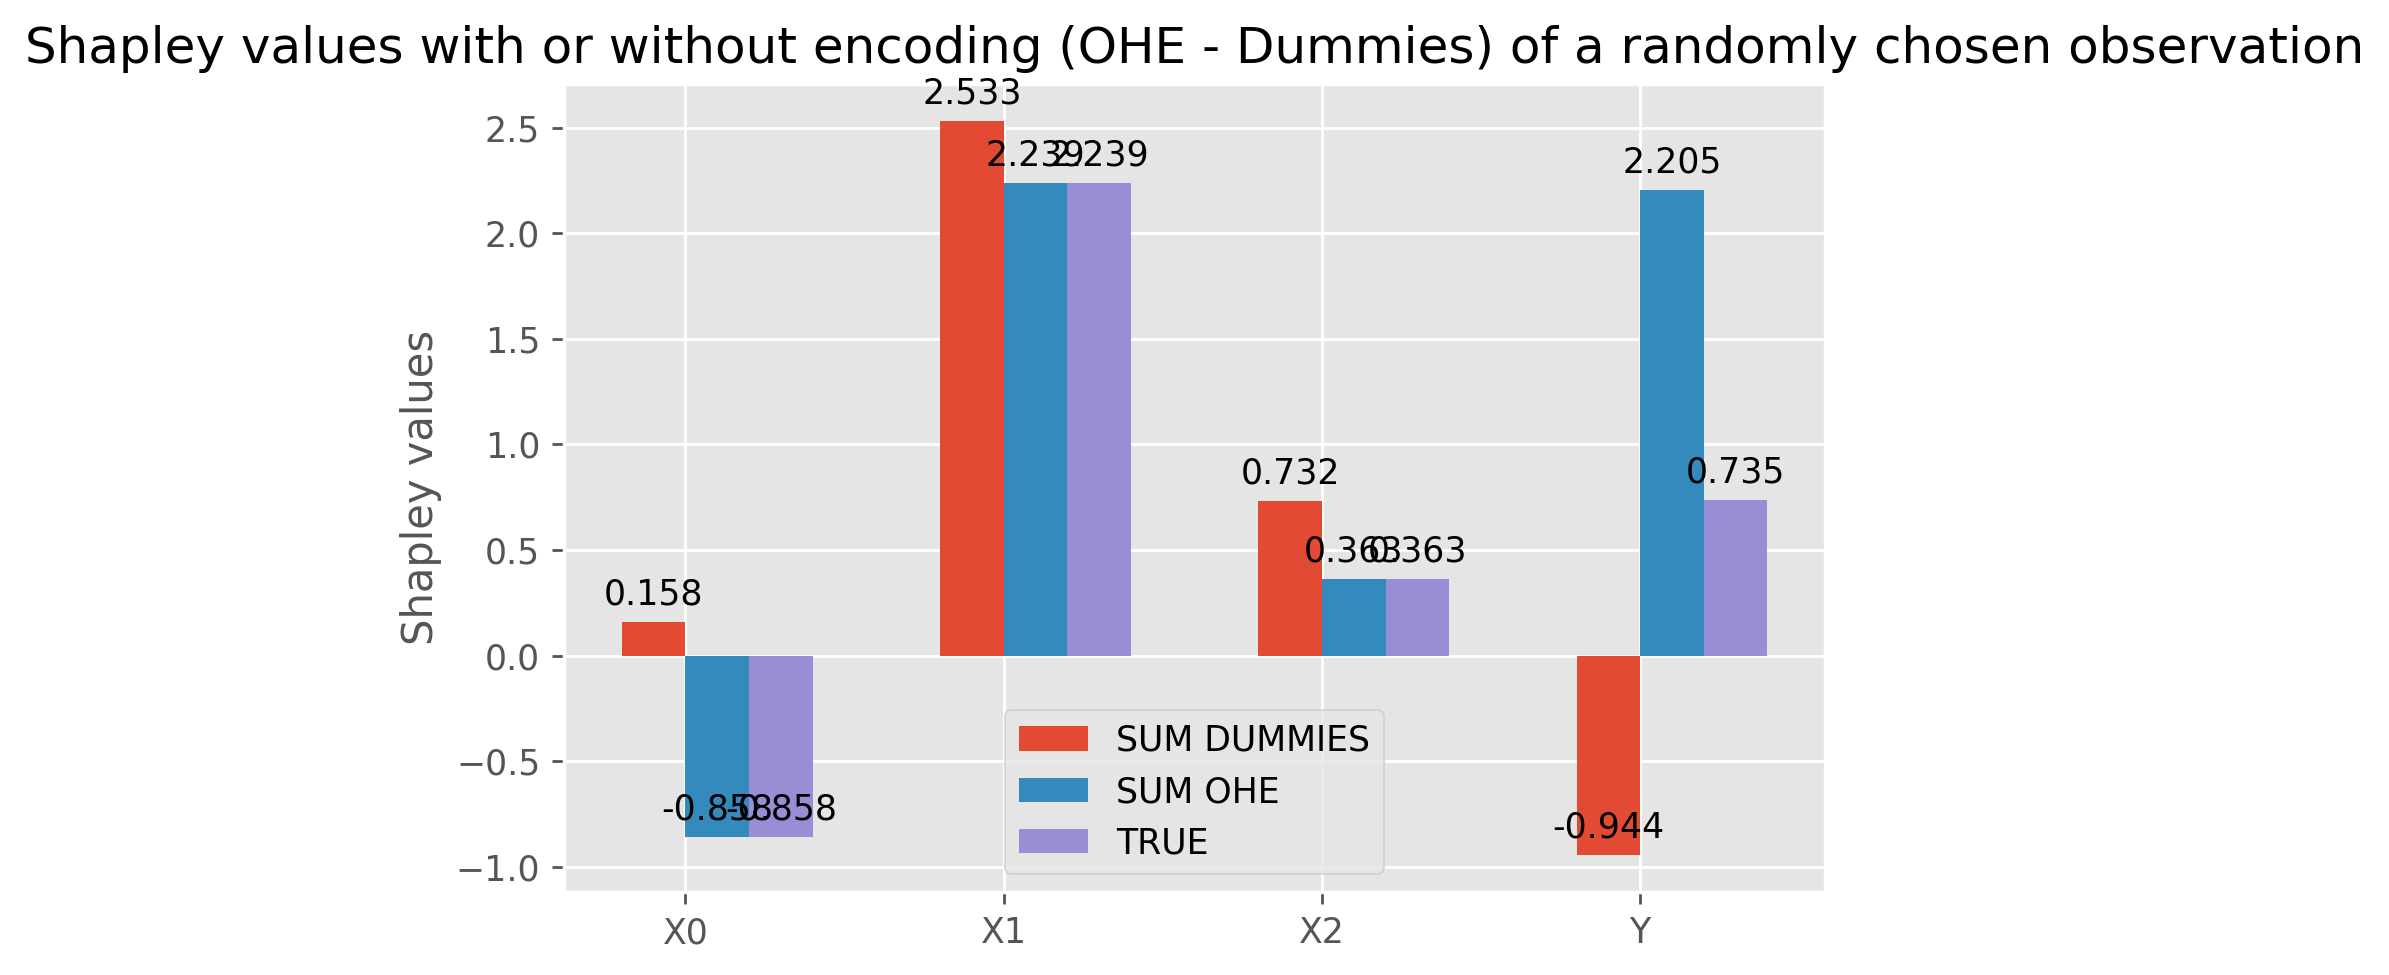

In [10]:
# idx = np.random.randint(0, nb)
idx = 53
bar_plot(s_shap_sum[idx][:-1], s_shap_ohe_sum[idx][:-2], s_shap_c[idx][:-1], labels=['SUM DUMMIES', 'SUM OHE', 'TRUE'],
         variables_name=variables_name, 
         title='Shapley values with or without encoding (OHE - Dummies) of a randomly chosen observation')

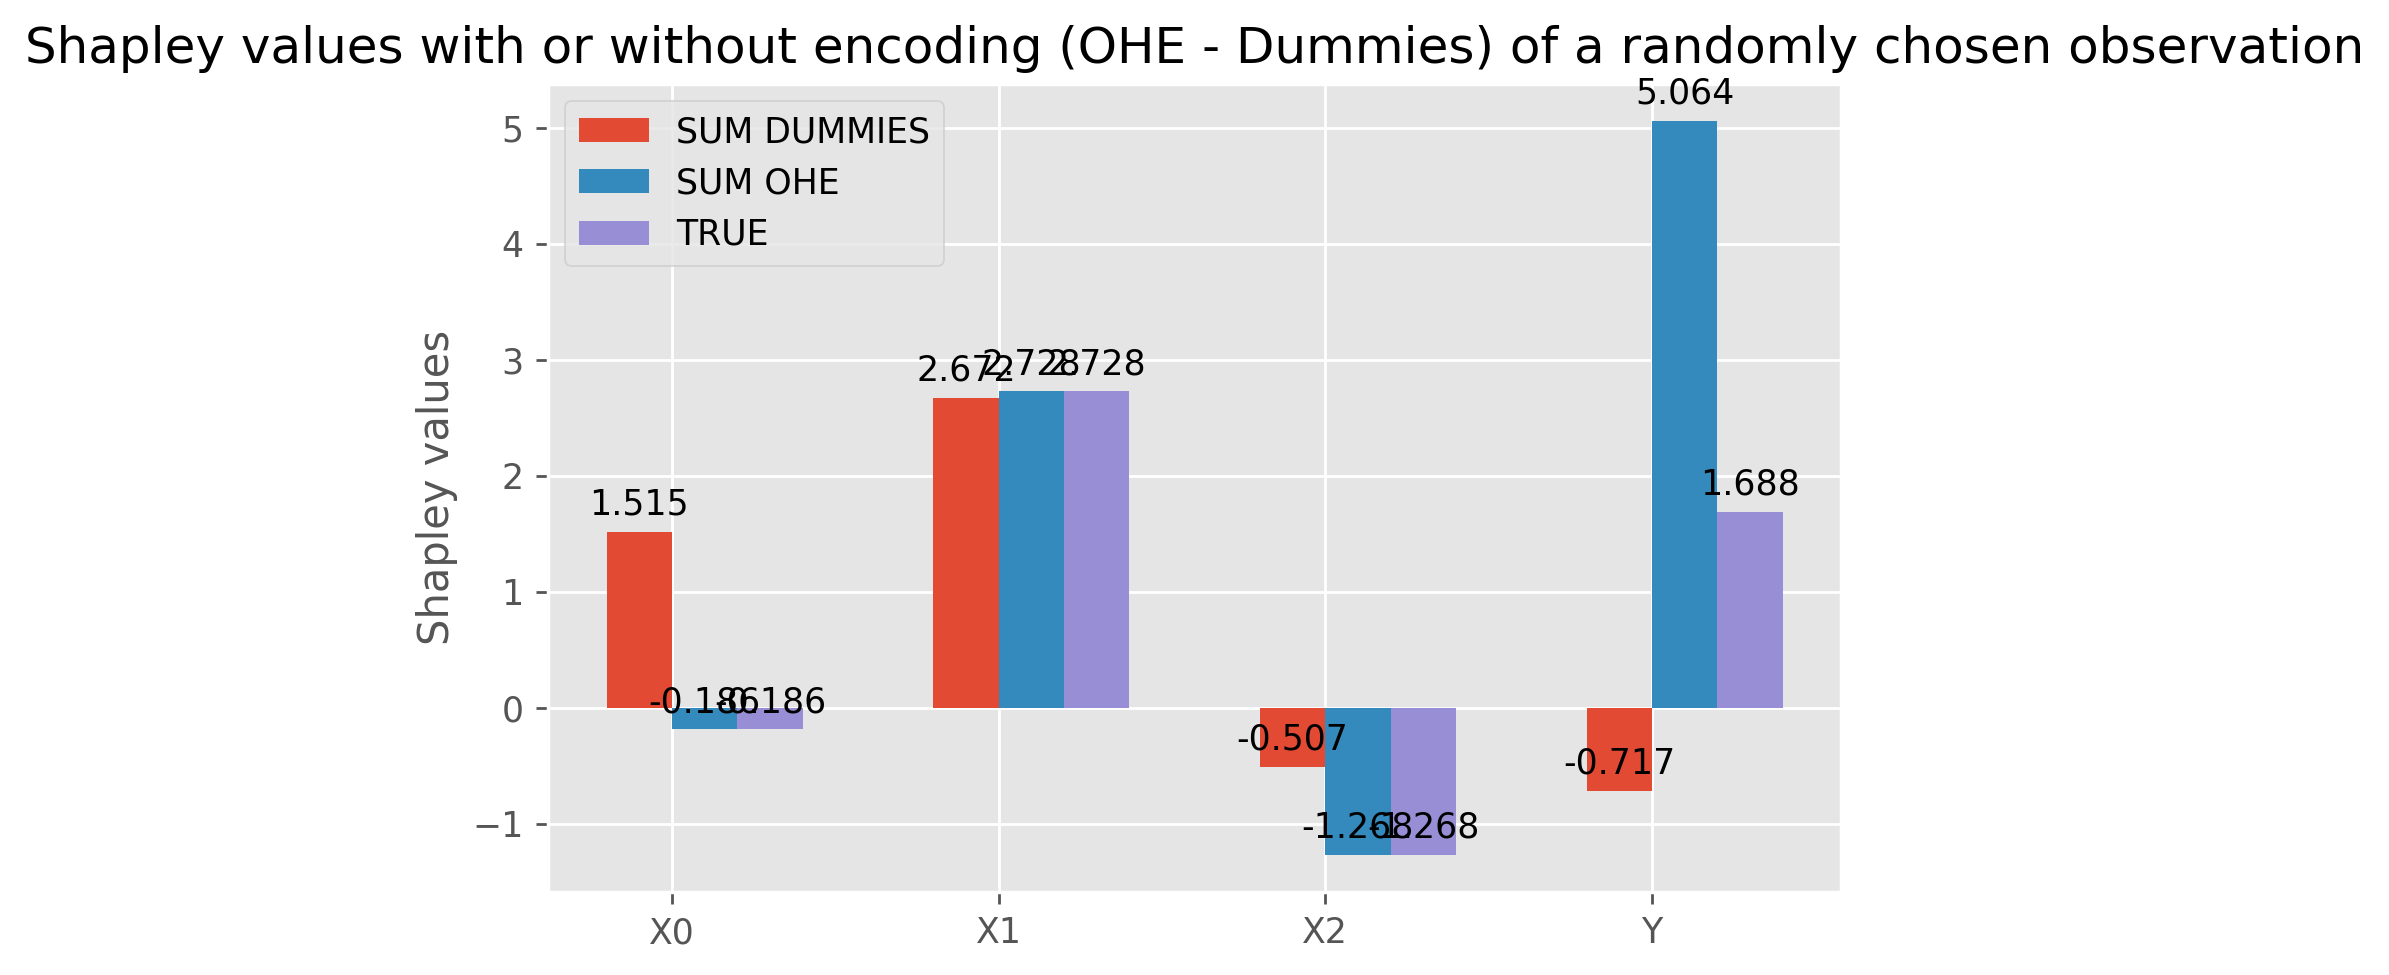

In [11]:
idx = 47
bar_plot(s_shap_sum[idx][:-1], s_shap_ohe_sum[idx][:-2], s_shap_c[idx][:-1], labels=['SUM DUMMIES', 'SUM OHE', 'TRUE'],
         variables_name=variables_name, 
         title='Shapley values with or without encoding (OHE - Dummies) of a randomly chosen observation')

### Figure 1: Shapley values with or without encoding (OHE - Dummies) for observation $x = [-1.15,  3.50, -1.28, 1, 0]$.

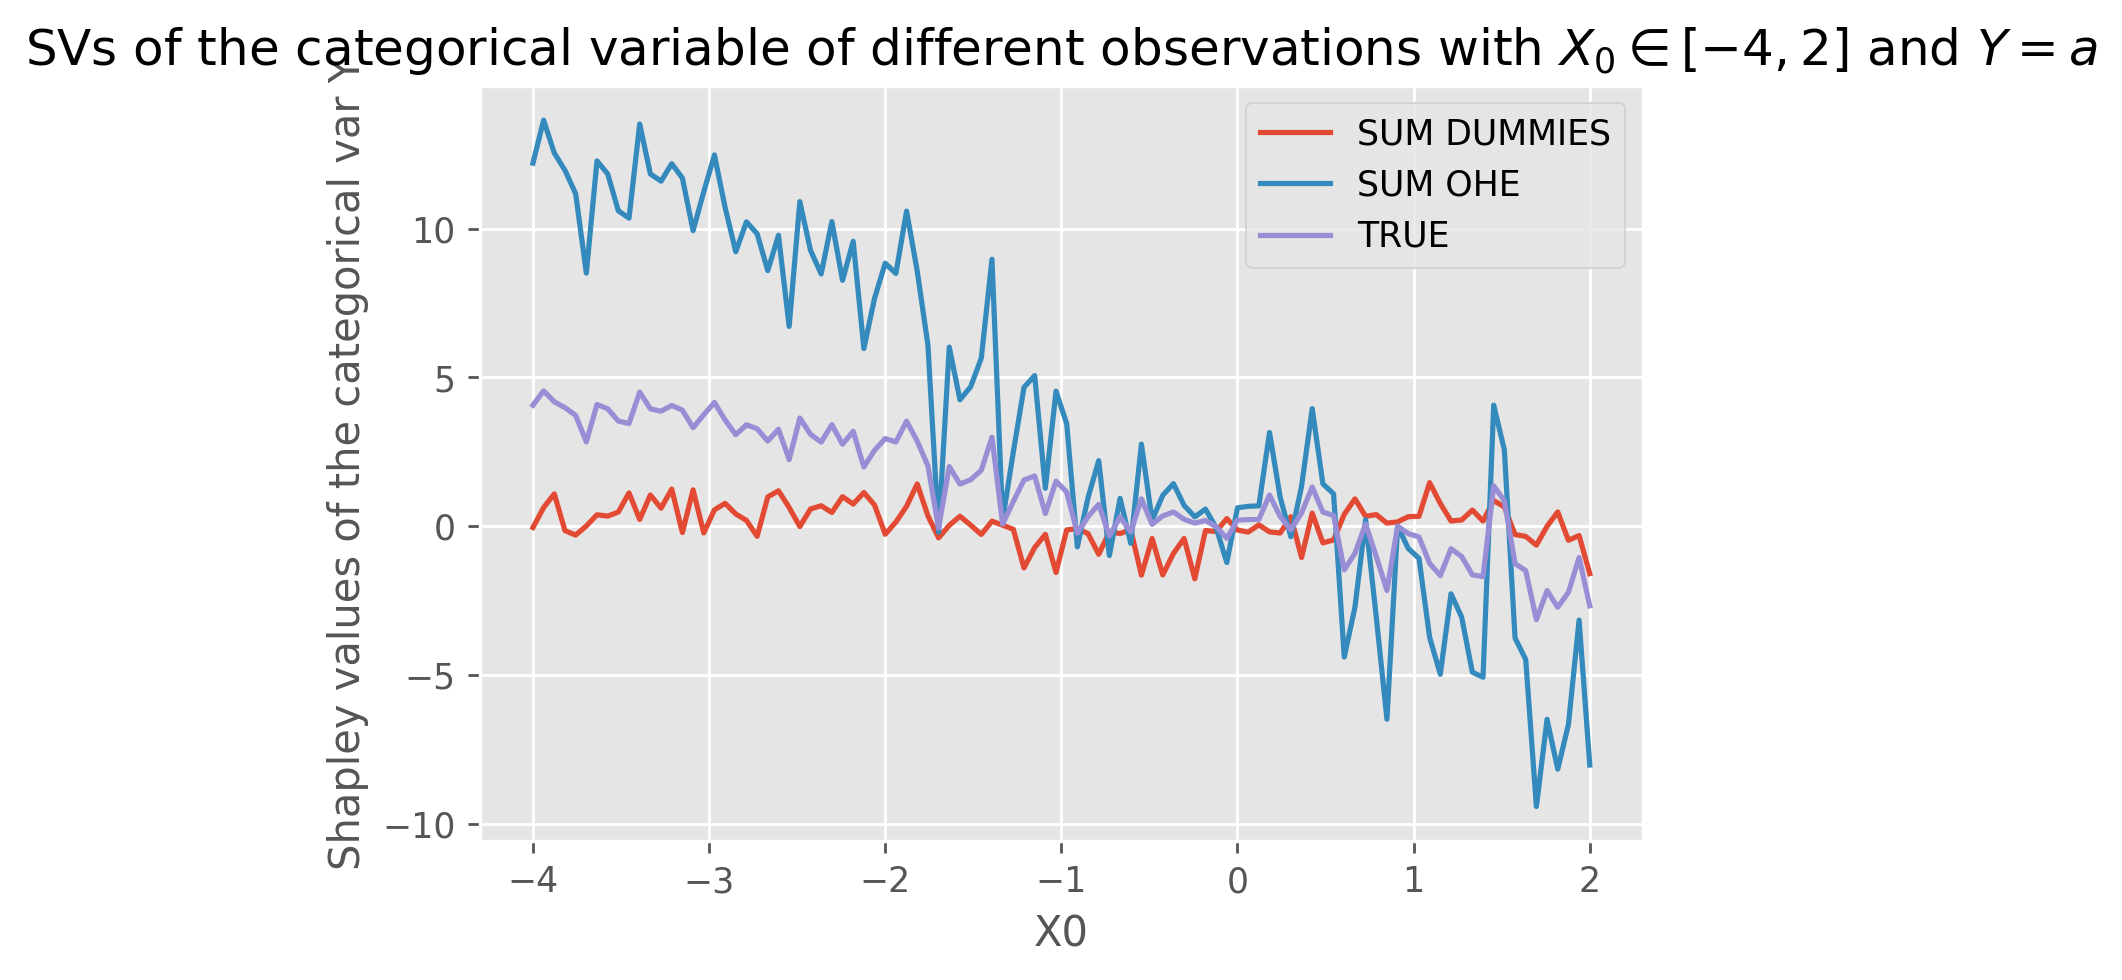

In [12]:
plt.figure(dpi=250)
plt.plot(x_0, s_shap_sum[:, 4], label='SUM DUMMIES')
plt.plot(x_0, s_shap_ohe_sum[:, 4], label='SUM OHE')
plt.plot(x_0, s_shap_c[:, 4], label='TRUE')
plt.ylabel('Shapley values of the categorical var Y')
plt.xlabel('X0')
plt.title('SVs of the categorical variable of different observations with ' + r'$X_0 \in \left[-4, 2\right]$'+' and '+r'$Y=a$')
plt.legend()

### Figure 2: SV of the categorical variable of different observations with $X_0 \in \left[-4, 2\right]$ and $Y=a$.

In [13]:
variables_name = ['X{}'.format(i) for i in range(len(s_shap_c[0])-2)] + ['Y_a', 'Y_b']

In [14]:
shap_data = np.concatenate([np.array(s_shap_sum), np.array(s_shap_ohe_sum)[:, :-1], np.array(s_shap_c)], axis=0)

In [15]:
shap_dataFra = pd.DataFrame(data=shap_data, columns=variables_name)

In [16]:
shap_dataFra['label'] = nb*['SUM DUMMIES'] + nb*['SUM OHE'] + nb*['TRUE']

Text(0.5, 1.0, 'errors boxplot')

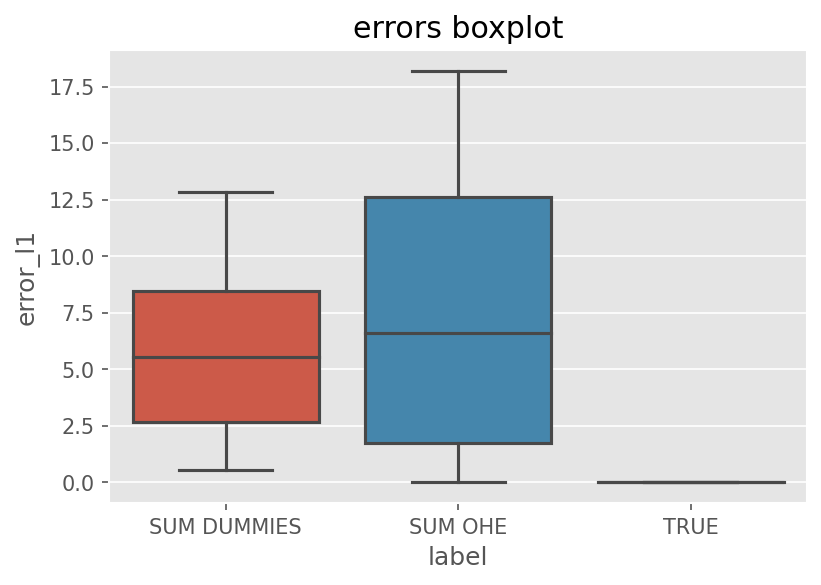

In [17]:
err_true = l1_norm(s_shap_c-s_shap_c)
err_dummies = l1_norm(s_shap_sum-s_shap_c)
err_ohe = l1_norm(s_shap_ohe_sum[:, :-1]-s_shap_c)

err_concat = np.concatenate([err_dummies, err_ohe, err_true], axis=0)

shap_dataFra['error_l1'] = err_concat

fig, ax = plt.subplots(dpi=150)
sns.boxplot(data=shap_dataFra, x='label', y='error_l1')
plt.title('errors boxplot')